# Sentiment scores for specific topics

In [1]:
import datetime
import os
import re
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
DATADIRECTORYSENT = "../data/sentiment/ALL-pattern/"
DATADIRECTORYTEXT = "../data/text/"
SENTIMENT = "sentiment"
COUNT = "count"
DATA = "data"
LABEL = "label"
HIGHLIGHT = "highlight"
HIGHLIGHTLABEL = "highlightlabel"
IDSTR = "id_str"
TEXT = "text"

In [18]:
def selectSentText(dfSent,dfText,patternText):
    sentimentScores = [] 
    for key in dfSent.index:
        if key in dfText.index and re.search(patternText,dfText.loc[key][TEXT],flags=re.IGNORECASE):
            sentimentScores.append(dfSent.loc[key][1])
    return(sentimentScores)

def getSentimentPerHourText(sentDirectory,textDirectory,patternText,patternDate=""):
    fileListSent = sorted(os.listdir(sentDirectory))
    fileListText = sorted(os.listdir(textDirectory))
    sentimentPerHour = {}
    for inFileName in fileListSent:
        if re.search(patternDate,inFileName) and re.search(r"2*z",inFileName) and inFileName in fileListText:
            if re.search("-00",inFileName):
                clear_output(wait=True)
                print(inFileName)
            try:
                dfSent = pd.read_csv(sentDirectory+inFileName,compression="gzip",header=None,index_col=0)
                dfText = pd.read_csv(textDirectory+inFileName,compression="gzip",index_col=IDSTR)
            except: continue
            sentimentScores = selectSentText(dfSent,dfText,patternText)
            if len(sentimentScores) > 0:
                hour = inFileName[0:11]
                sentimentPerHour[hour] = { SENTIMENT:np.average(sentimentScores), COUNT:len(sentimentScores) }
    sentimentPerHour = {key:sentimentPerHour[key] for key in sorted(sentimentPerHour.keys())}
    return(sentimentPerHour)

def getSentimentPerHourAll(sentDirectory,patternDate=""):
    fileListSent = sorted(os.listdir(sentDirectory))
    sentimentPerHour = {}
    for inFileName in fileListSent:
        if re.search(patternDate,inFileName) and re.search(r"2*z",inFileName):
            if re.search("-00",inFileName):
                clear_output(wait=True)
                print(inFileName)
            try:
                dfSent = pd.read_csv(sentDirectory+inFileName,compression="gzip",header=None,index_col=0)
            except: continue
            if len(dfSent) > 0:
                hour = inFileName[0:11]
                sentimentPerHour[hour] = { SENTIMENT:np.average(dfSent[1]), COUNT:len(dfSent) }
    sentimentPerHour = {key:sentimentPerHour[key] for key in sorted(sentimentPerHour.keys())}
    return(sentimentPerHour)

In [4]:
def makeSentimentPerDay(sentimentPerHour):
    sentimentPerDay = {}
    for hour in sentimentPerHour:
        day = re.sub("..$","12",hour)
        if not day in sentimentPerDay: sentimentPerDay[day] = {SENTIMENT:0,COUNT:0}
        sentimentPerDay[day][SENTIMENT] += sentimentPerHour[hour][SENTIMENT]*sentimentPerHour[hour][COUNT]
        sentimentPerDay[day][COUNT] += sentimentPerHour[hour][COUNT]
    for day in sentimentPerDay:
        sentimentPerDay[day][SENTIMENT] /= sentimentPerDay[day][COUNT]
    return(sentimentPerDay)

In [5]:
%matplotlib notebook

DATEFORMATHOUR = "%Y%m%d-%H"
DEFAULTTITLE = "Sentiment scores of Dutch tweets"

def visualizeSentiment(dataSources,title=DEFAULTTITLE):
    fig,ax = plt.subplots(figsize=(9,4))
    for i in range(0,len(dataSources)):
        data = dataSources[i][DATA]
        label = dataSources[i][LABEL]
        lineData= ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in data],\
                     [data[key] for key in data],xdate=True,fmt="-",label=label)
        if HIGHLIGHT in dataSources[i]:
            highlight = dataSources[i][HIGHLIGHT]
            highlightlabel = dataSources[i][HIGHLIGHTLABEL]
            color = lineData[-1].get_color()
            ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in highlight],
                         [data[key] for key in highlight],\
                         fmt="o",color=color,label=highlightlabel)
                
    plt.title(title)
    plt.legend()
    plt.show()
    return(ax)

In [6]:
def averageSentiment(sentimentScores):
    return(np.average([sentimentScores[key][SENTIMENT] for key in sentimentScores],\
                      weights=[sentimentScores[key][COUNT] for key in sentimentScores]))

def writeSentiment(sentimentScores,fileName):
    pd.DataFrame(sentimentScores).T.to_csv(fileName,index_label="date")
    
def readSentiment(fileName):
    return(pd.read_csv(fileName,index_col="date").T.to_dict())

## Extract sentiment scores from tweets (takes several hours)

In [55]:
QUERY = "#corona|#covid|#flattenthecurve|#blijfthuis|#rivm|#mondkapje|#huisarts|#houvol|#zorg"
QUERY = "corona|covid|flattenthecurve|blijfthuis|rivm|mondkapje|huisarts|houvol|zorg"
SENTDIR = "../data/sentiment/"
PATTERNDATE = ""

sentimentPerHour = getSentimentPerHourText(DATADIRECTORYSENT,DATADIRECTORYTEXT,QUERY,patternDate=PATTERNDATE)
writeSentiment(sentimentPerHour,SENTDIR+QUERY+".csv")

20200522-00.out.gz


In [53]:
sentimentPerHour = getSentimentPerHourAll(DATADIRECTORYSENT+"../2019/")

20190531-00.out.gz


In [54]:
writeSentiment(sentimentPerHour,SENTDIR+"tmp.csv")
sentimentPerHour

{'20190201-00': {'sentiment': 0.07282782533921743, 'count': 13006},
 '20190201-01': {'sentiment': 0.06805918938585198, 'count': 5282},
 '20190201-02': {'sentiment': 0.06682158939882239, 'count': 3021},
 '20190201-03': {'sentiment': 0.07359067188512845, 'count': 2212},
 '20190201-04': {'sentiment': 0.06732549169131737, 'count': 2397},
 '20190201-05': {'sentiment': 0.08196633728616713, 'count': 3563},
 '20190201-06': {'sentiment': 0.08365976521282786, 'count': 7964},
 '20190201-07': {'sentiment': 0.09910211286972775, 'count': 17277},
 '20190201-08': {'sentiment': 0.0961687377512087, 'count': 24890},
 '20190201-09': {'sentiment': 0.09885708451648718, 'count': 29798},
 '20190201-10': {'sentiment': 0.09478920327010426, 'count': 31532},
 '20190201-11': {'sentiment': 0.09645225365995858, 'count': 31183},
 '20190201-12': {'sentiment': 0.09174272592874484, 'count': 31000},
 '20190201-13': {'sentiment': 0.09354738982457653, 'count': 29997},
 '20190201-14': {'sentiment': 0.09088575672753973, 'cou

<IPython.core.display.Javascript object>


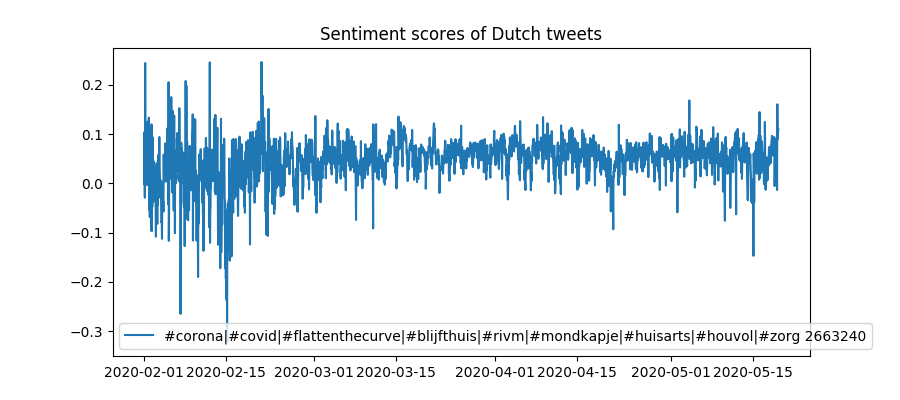

In [59]:
dummy = visualizeSentiment([{DATA:{key:sentimentPerHour[key][SENTIMENT] for key in sentimentPerHour},
                             LABEL:QUERY+" "+\
                             str(sum([sentimentPerHour[key][COUNT] for key in sentimentPerHour]))}],\
                           title=DEFAULTTITLE)

In [64]:
SENTDIR = "../data/sentiment/"

sentimentPerHour = {}
sentimentPerDay = {}

for inFileName in os.listdir(SENTDIR):
    if re.search(r".csv$",inFileName):
        query = inFileName[:-4]
        sentimentPerHour[query] = readSentiment(SENTDIR+inFileName)
        sentimentPerDay[query] = makeSentimentPerDay(sentimentPerHour[query])

In [65]:
averageSentiment(sentimentPerHour["mondkapje"])

0.02805679410337243

<IPython.core.display.Javascript object>


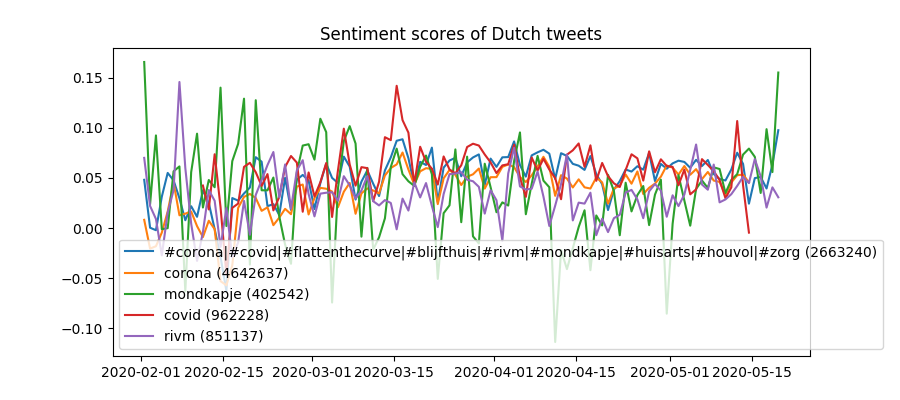

In [66]:
plotData = []
for term in reversed(list(sentimentPerDay.keys())):
    plotData.append({DATA:{key:sentimentPerDay[term][key][SENTIMENT] for key in sentimentPerDay[term]},
                             LABEL:term+" ("+\
                             str(round(sum([sentimentPerDay[term][key][COUNT]\
                                      for key in sentimentPerDay[term]])))+")"})
    
dummy = visualizeSentiment(plotData,title=DEFAULTTITLE)

<IPython.core.display.Javascript object>


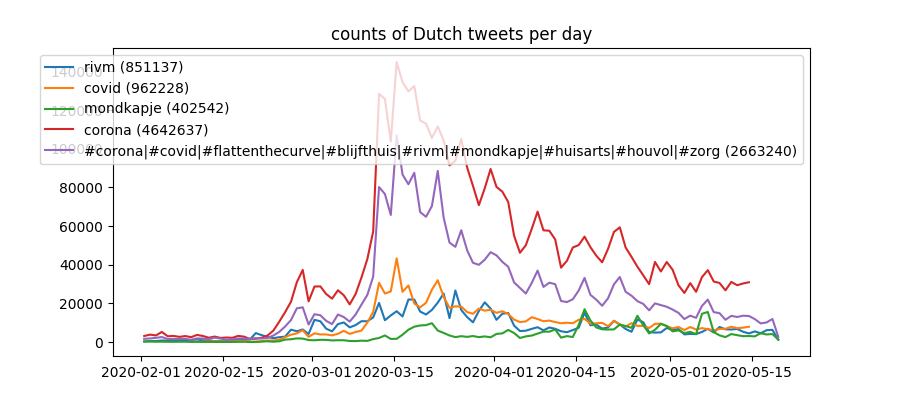

In [67]:
plotData = []
for term in sentimentPerDay.keys():
    plotData.append({DATA:{key:sentimentPerDay[term][key][COUNT] for key in sentimentPerDay[term]},
                             LABEL:term+" ("+\
                             str(round(sum([sentimentPerDay[term][key][COUNT]\
                                      for key in sentimentPerDay[term]])))+")"})
    
dummy = visualizeSentiment(plotData,title="counts of Dutch tweets per day")

## Check query "test"

In [48]:
INFILENAME = "20200518-12.out.gz"
df = pd.read_csv(DATADIRECTORYTEXT+INFILENAME,compression="gzip",index_col=IDSTR)

In [49]:
QUERY = "zorg"

tokens = {}
for key in df.index:
    for token in df.loc[key][0].split():
        if re.search(QUERY,token,flags=re.IGNORECASE):
            token = token.lower()
            if token in tokens: tokens[token] += 1
            else: tokens[token] = 1

In [50]:
{token:tokens[token] for token,count in sorted(tokens.items(),key=lambda item:item[1], reverse=True)}

{'zorg': 140,
 'zorgen': 99,
 'zorgt': 55,
 'gezondheidszorg': 30,
 '#zorg': 27,
 'mantelzorgers,': 24,
 'pgb-zorgverleners': 22,
 'zorgvrijwilligers': 22,
 'bezorgde': 17,
 'geldzorgen.': 15,
 'gezondheidszorg,': 15,
 'nooit..\\n👉..verzorgingshuizen': 14,
 'bezorgen': 13,
 'zorg.': 13,
 'mantelzorgers': 13,
 'zorgen.': 11,
 'bezorgd': 11,
 'woonzorgcentra': 11,
 'gezorgd': 10,
 'zorgmedewerkers': 9,
 'zorgvuldig': 9,
 'zorgsector': 8,
 'zorgverleners': 8,
 'zorg,': 8,
 'verzorgen': 7,
 'zorgverslindende': 7,
 'zorgen,': 7,
 'thuisbezorgd': 7,
 'geldzorgen,': 6,
 'zorgmedewerkers,': 6,
 '@zorgmama2': 6,
 'zorgzame': 6,
 'bezorg': 5,
 'zorgmedewerkers.': 5,
 '#regulierezorg': 4,
 'zorgpersoneel': 4,
 'verzorgingstehuis': 4,
 'zorgde': 4,
 'bezorgd.': 4,
 'zorggids': 4,
 'voorzorg': 4,
 '#ouderenzorg!': 4,
 'bezorgen.': 3,
 'verzorgingshuis.': 3,
 'zorgelijk,': 3,
 'zorgen!': 3,
 'bezorgt': 3,
 'zorgt:': 3,
 'zorginstelling': 3,
 'intérieurverzorgster': 3,
 'verzorgende': 3,
 '#ikzorg': 